# letters: 0-255, spacer:256, blank(e):257

In [1]:
#! constant
BLANK_VAL = 257
dna_vocab = [f"_{x}_" for x in range(256)]#.append(['spacer','blank'])
dna_vocab.append('spacer')
dna_vocab.append('blank')
dna_vocab.append('_')

#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *


c:\Users\nntin\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\Users\nntin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:

class DNA_vocab:
    # character and index is the same for this task    
    def __init__(self, dna_vocab):
        self.dna_vocab = dna_vocab
    def vocab(self):
        return dna_vocab
    def id_to_subword(self,id):
        return dna_vocab[id]

In [3]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [4]:
# choosing file
print(os.getcwd())
data_file_name_train = "out_csv/full_spacer_detection_10k.csv"
data_file_name_val = "out_csv/full_spacer_detection.csv"
samples_per_sequence_train = 2
samples_per_sequence_val = 1


c:\Users\nntin\uni\fyp\fyp2023


In [5]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name_train, samples_per_sequence_train)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026b

100%|██████████| 10000/10000 [00:44<00:00, 225.79it/s]

Generated 20000 signals and 20000 labels in 46.625


In [6]:
start = time.monotonic()
signals_v,index_v,spacer_labels_v, letter_labels_v, barcode_labels_v, ctc_labels_v =prepare_train2(data_file_name_val, samples_per_sequence_val)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

100%|██████████| 1000/1000 [00:02<00:00, 469.26it/s]

Generated 20000 signals and 20000 labels in 2.3589999999967404


Letters: [51, 240, 169, 87, 101, 0, 229] 
barcodes: [0, 0] 
ctc_labels: [256, 51, 256, 240, 256, 169, 256, 87, 256, 101, 256, 0, 256, 229, 256]
[1930, 1933, 1707, 1722, 1980, 1908, 1856, 1993, 1953, 1865, 2043, 1773, 1877, 1857, 1947, 1842, 1797, 1811, 1851, 1821, 1820, 1950, 1999, 1938, 1922, 1700, 2016, 2192, 1881, 1913, 1740, 1988, 1724, 2030, 1862, 1802, 1824, 1887, 2003, 1863, 1958, 2004, 1963, 1985, 1904, 2231, 2136, 1958, 1833, 1966, 1894, 1819, 1965, 1904, 1946, 1979, 1786, 2067, 1951, 2003, 1813, 1928, 1670, 1791, 1970, 2062, 1944, 2011, 1860, 1910, 2178, 2071, 2081, 1941, 2062, 2098, 1821, 1903, 1688, 1916, 1847, 1918, 1946, 2259, 2047, 2045, 1895, 1848, 1760, 1816, 1851, 1931, 2086, 2038, 1813, 2105, 2067, 1582, 1804, 1971, 1706, 1866, 1771, 1856, 1979, 1928, 2095, 2035, 2088, 1906, 2154, 1956, 1901, 1871, 1961, 1992, 2035, 1919, 1966, 2146, 2031, 1722, 1894, 1970, 2018, 1900, 1969, 1819, 2066, 1894, 1829, 1652, 1748, 1872, 1814, 1807, 1875, 1844, 1789, 1676, 1881, 1978, 192

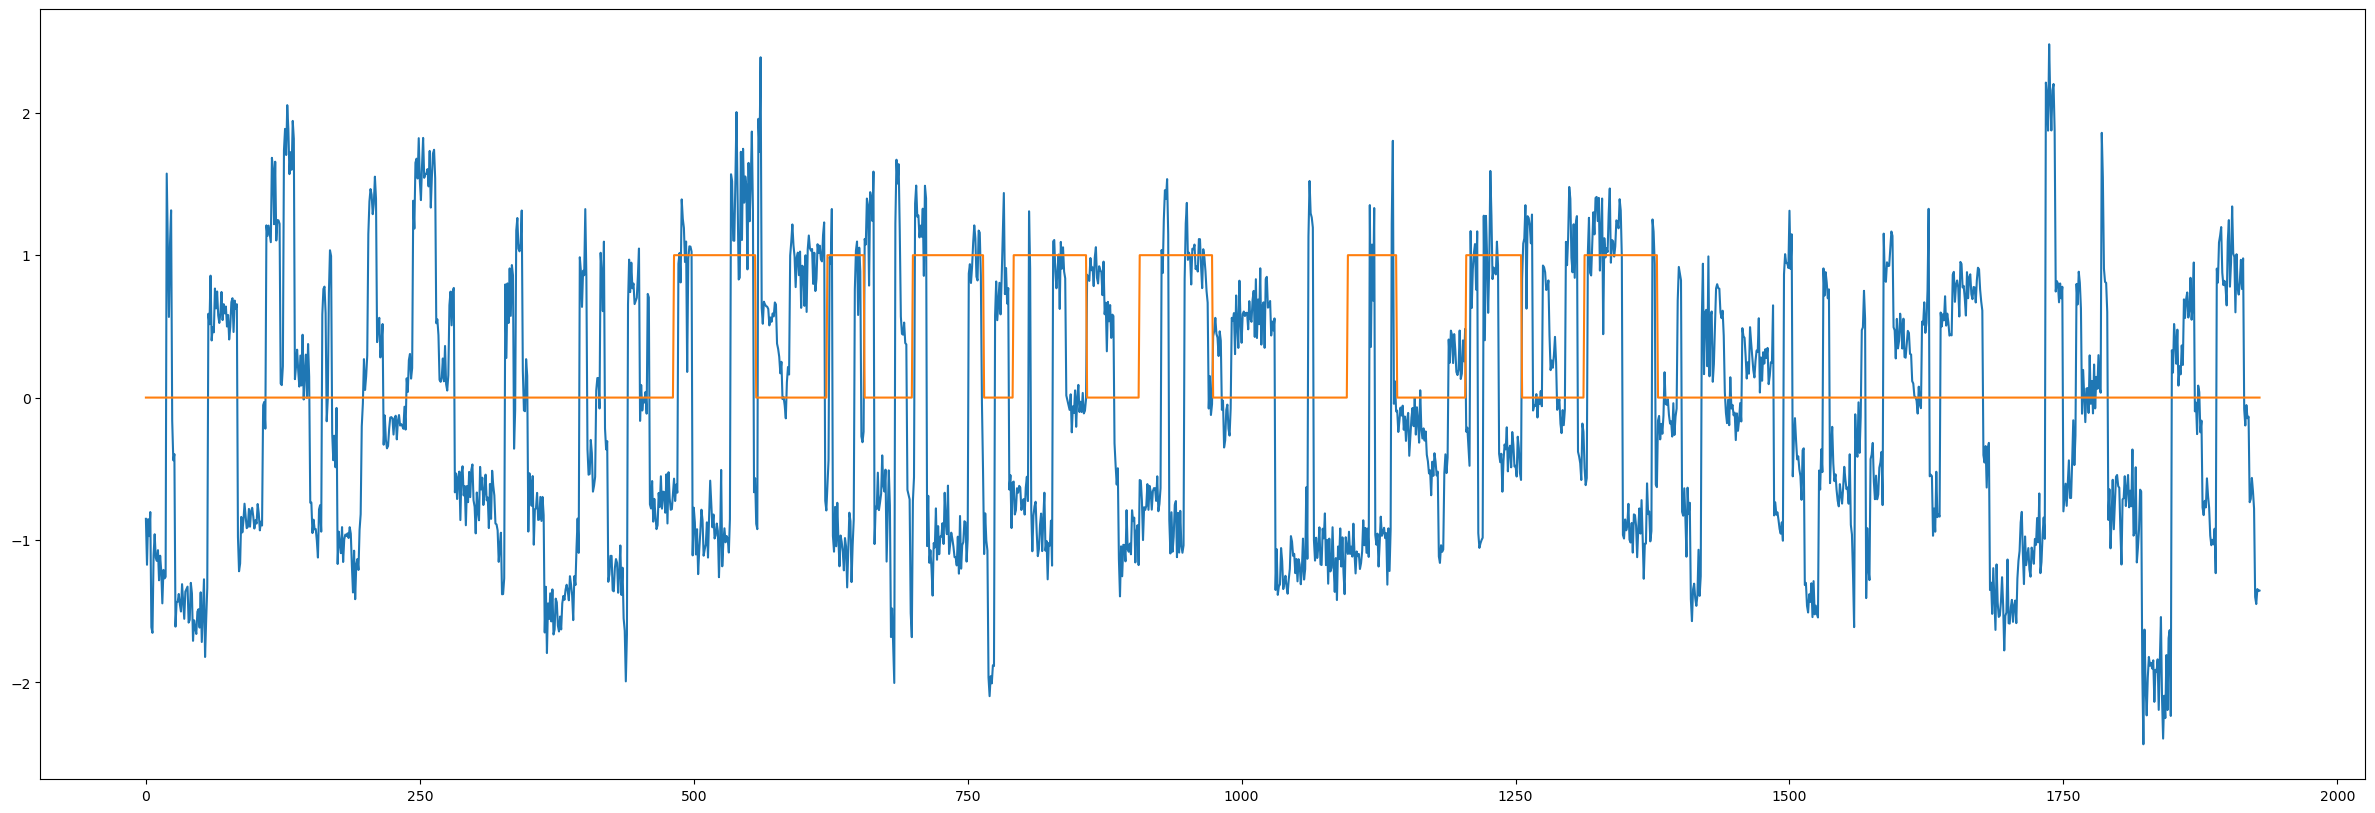

In [7]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

# print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

In [8]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [9]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [10]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'DNA_FYP_2023', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 258, 'feat_in': 1}}

In [11]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)
bpe = DNA_vocab(dna_vocab)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze() #! Tin add
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get(
    #         'sample_rate', 16000),  # for LJspeech
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad(), # pad both audio and text
    AudioUnsqueeze() #! Tin add
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals_v,ctc_labels_v)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

# print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()


criterion = nn.CTCLoss(blank=BLANK_VAL, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe,blank_index=BLANK_VAL,space_simbol='_')

prev_wer = 1000
#! TIN CHNAGE
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

label
['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nguyennhuttin (monash-deep-neuron). Use `wandb login --relogin` to force relogin


[]

In [12]:

for epoch_idx in tqdm(range(config.train.get('epochs', 10))):
    # train:
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        batch1=batch
        # print(len(batch1['audio'][0]))
        batch = batch_transforms_train(batch)
        batch2=batch
        # print(len(batch2['audio'][0]))

        optimizer.zero_grad()
        logits = model(batch['audio'].float())
        
        output_length = torch.ceil(
            batch['input_lengths'].float() / model.stride).int()
        
        # print('batch audio shape:', batch['audio'].shape, batch['audio'].dtype )
        # print('logits shape:', logits.shape)
        # print('output_length shape:',output_length)
        # print('target_lengths:',batch['target_lengths'])
        
        loss = criterion(logits.permute(2, 0, 1).log_softmax(
            dim=2), batch['text'], output_length, batch['target_lengths']) # target_length is the length of text of batch1 (before batch aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config.train.get('clip_grad_norm', 15))
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()
        # break
        if batch_idx % config.wandb.get('log_interval', 5000) == 0:
            target_strings = decoder.convert_to_strings(batch['text'])
            decoded_output = decoder.decode(
                logits.permute(0, 2, 1).softmax(dim=2))
            wer = np.mean([decoder.wer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            cer = np.mean([decoder.cer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            step = epoch_idx * \
                len(train_dataloader) * train_dataloader.batch_size + \
                batch_idx * train_dataloader.batch_size
            #! TIN change
            wandb.log({
                "train_loss": loss.item(),
                "train_wer": wer,
                "train_cer": cer,
                "train_samples": wandb.Table(
                    columns=['gt_text', 'pred_text'],
                    data=list(zip(target_strings, decoded_output))
                )
            }, step=step)
        # print(decoded_output)
    #!
    # validate:
    model.eval()
    val_stats = defaultdict(list)
    for batch_idx, batch in enumerate(val_dataloader):
        batch = batch_transforms_val(batch)
        with torch.no_grad():
            logits = model(batch['audio'].float())
            output_length = torch.ceil(
                batch['input_lengths'].float() / model.stride).int()
            loss = criterion(logits.permute(2, 0, 1).log_softmax(
                dim=2), batch['text'], output_length, batch['target_lengths'])

        target_strings = decoder.convert_to_strings(batch['text'])
        decoded_output = decoder.decode(
            logits.permute(0, 2, 1).softmax(dim=2))
        wer = np.mean([decoder.wer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        cer = np.mean([decoder.cer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        val_stats['val_loss'].append(loss.item())
        val_stats['wer'].append(wer)
        val_stats['cer'].append(cer)
    for k, v in val_stats.items():
        val_stats[k] = np.mean(v)
    val_stats['val_samples'] = wandb.Table(
        columns=['gt_text', 'pred_text'], data=list(zip(target_strings, decoded_output)))
    wandb.log(val_stats, step=step)

    # save model, TODO: save optimizer:
    if val_stats['wer'] < prev_wer:
        os.makedirs(config.train.get(
            'checkpoint_path', 'checkpoints'), exist_ok=True)
        prev_wer = val_stats['wer']
        torch.save(
            model.state_dict(),
            os.path.join(config.train.get(
                'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth')
        )
        try:
            wandb.save(os.path.join(config.train.get(
                'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth'))
        except:
            print('could not use wandb save')
    # break

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
target_strings

['spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_184_spacer_238_spacer_43_spacer_142_spacer_89_spacer_135_spacer_169_spacer',
 'spacer_184_spacer_238_spacer_43_spacer_142_spacer_89_spacer_135_spacer_169_spacer']

In [ ]:
decoded_output

['spacerspacerspacer',
 'spacer',
 'spacerspacerspacer',
 'spacerspacer',
 'spacerspacerspacerspacer',
 'spacer',
 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer',
 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']

In [ ]:
logits.permute(2, 0, 1).log_softmax(
            dim=2).shape

torch.Size([1035, 1, 258])

In [ ]:
batch2.keys()

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])

In [ ]:
batch2['input_lengths']

tensor([2070], device='cuda:0')

In [ ]:
print(len(batch1['audio'])) # batchsize
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(max([len(x) for x in batch1['audio'] ]))

1
2070
1
2070
